In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

In [2]:
#new line for initial concentration
initial_concentration=1

def I(x):
    L = x[-1]
    len_x = np.size(x)
    i_x = np.zeros(len_x)
    for i in range(len_x):
        if x[i] < (L+1)/2 and x[i] > (L-1)/2:
            i_x[i] = initial_concentration
    return i_x

def U_exact(x, t):
    L = x[-1]
    u_ex = np.ones(np.size(x)) * (1/L)
    
    for n in range(1,2000):
        c_n = (2 / (n * np.pi)) * (np.sin((n * np.pi * (L + 1)) / (2 * L)) - np.sin((n * np.pi * (L - 1)) / (2 * L)))
        
        u_ex += c_n * np.cos(n*np.pi*x / L)*np.exp(-1*n** 2 * np.pi**2 * t / L **2)
        
    return u_ex

In [3]:
L=10; T=2

#made spaces and gaps depend on L and T to keep resolution the same when increasing time/length
Nx_spaces = 40*L; Nt_gaps = 50*T; 
Nx_points = Nx_spaces +  1 ; Nt_points = Nt_gaps + 1

x = np.linspace(0, L, Nx_points)   # mesh points in space
dx = x[1] - x[0]

t = np.linspace(0, T, Nt_points) # mesh points in time
dt = t[1] - t[0]

C = dt/dx**2
print("dx=",dx,"dt=", dt,"C =",C)

# set up matrices
u   = np.zeros(Nx_points)
u_old = np.zeros(Nx_points)

U = np.zeros((Nx_points,Nt_points))
U_ex = np.zeros((Nx_points, Nt_points))

# Data structures for the linear system
A = np.zeros((Nx_points, Nx_points))
b = np.zeros(Nx_points)

# set up the matrix A
for i in range(1, Nx_points-1): # rows from 1 to Nx-2
    A[i,i-1] = -C
    A[i,i+1] = -C
    A[i,i] = 1 + 2*C
A[0,0] = 1+2*C  ; A[0,1]= -2*C 
A[Nx_points-1,Nx_points-1] = 1+2*C 
A[Nx_points-1,Nx_points-2] = -2*C

# find the inverse of A and use for all points
Ainv = np.linalg.inv(A)

# Set initial condition u(x,0) = I(x)
u_old = I(x) # no dirichlet boundary conditions in this example

# initialise matrices U and U_ex2 for first time step
U[:,0] = u_old[:]
U_ex[:,0]=U_exact(x,0)

#perform time=stepping
for n in range(1, Nt_points): # timestep for 1 to t = T-1 so last step finishes on t=T
    # Compute b and solve linear system
    b[:] = u_old[:]
    u[:] = np.dot(Ainv,b)
    # Update u_1 before next step
    u_old = u
    U[:,n] = u
    U_ex[:,n]=U_exact(x,t[n])

dx= 0.025 dt= 0.02 C = 31.999999999999993


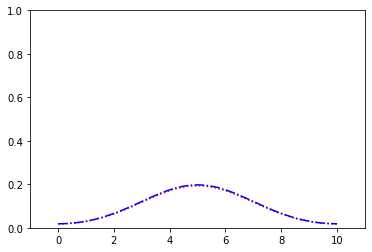

In [4]:
# set up animation plots
fig, ax = plt.subplots()
ax.axis([-1,1+L,0,1])
def animate(i):
    l.set_data(x, U[:,i])
    m.set_data(x,U_ex[:,i])
    
ax.axis([-1,1+L,0,1])
l, = ax.plot([],[],':r')
m, = ax.plot([],[],'-.b')

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=Nt_points)

from IPython.display import HTML
HTML(ani2.to_jshtml())

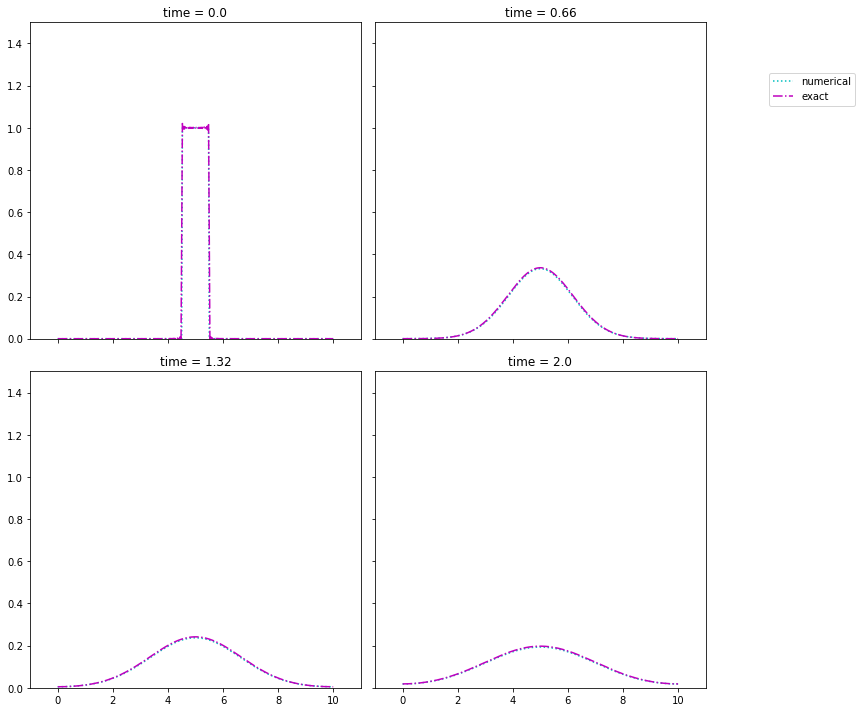

In [5]:
times = np.linspace(0, Nt_gaps, 4, dtype = int)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize= (10,10))


ax[0, 0].axis([-1, 1+L, 0, 1.5])
ax[1, 0].axis([-1, 1+L, 0, 1.5])
ax[0, 1].axis([-1, 1+L, 0, 1.5])
ax[1, 1].axis([-1, 1+L, 0, 1.5])

ax[0, 0].plot(x, U[:, times[0]], ':c', label = 'numerical')
ax[0, 0].plot(x, U_ex[:, times[0]], '-.m', label = 'exact')
ax[0, 0].set_title(f'time = {t[times[0]]}')

ax[0, 1].plot(x, U[:, times[1]], ':c')
ax[0, 1].plot(x, U_ex[:, times[1]], '-.m')
ax[0, 1].set_title(f'time = {t[times[1]]}')

ax[1, 0].plot(x, U[:, times[2]], ':c')
ax[1, 0].plot(x, U_ex[:, times[2]], '-.m')
ax[1, 0].set_title(f'time = {t[times[2]]}')

ax[1, 1].plot(x, U[:, times[3]], ':c')
ax[1, 1].plot(x, U_ex[:, times[3]], '-.m')
ax[1, 1].set_title(f'time = {t[times[3]]}')


fig.legend(bbox_to_anchor= (1.2, 0.9))
plt.tight_layout()

In [6]:
# detector detects at 1/100 concentration
detection_threshold=(1/100)*initial_concentration

def detector(position,time,detection_threshold=detection_threshold,x=x,U=U):
    '''Test if gas is detected at specified position and time'''
    position_step=int(Nx_spaces*position/L)
    time_step=int(Nt_gaps*time/T)
    return detector_step(position_step,time_step,x,U)

def detector_step(position_step,time_step,x=x,U=U):
    '''Test if gas is detected at specified position and time steps'''
    #print(position_step,time_step)
    concentration=U[:,time_step]
    return concentration[position_step] >= detection_threshold

#test
detector(L/2,0)

True

In [7]:
def detection_points(detection_threshold=detection_threshold):
    '''Loop over all frames and test if gas can be detected'''
    points_of_detection = []
    for time in t:
        for position in x:
            if (detector(position,time,detection_threshold=detection_threshold)):
                points_of_detection.append([position,time])
    return(points_of_detection)

In [147]:
def detection_points_plot_single(points_of_detection,color=None):
    '''plot points'''
    plt.scatter(*zip(*points_of_detection),color=color)
    #print(len(points_of_detection))
    plt.axis([0, L, 0, T])
    plt.ylabel('Time')
    plt.xlabel('Detector Position')
    plt.title(f'Detections in time and space for detection concentration {detection_threshold}.')
    plt.show()

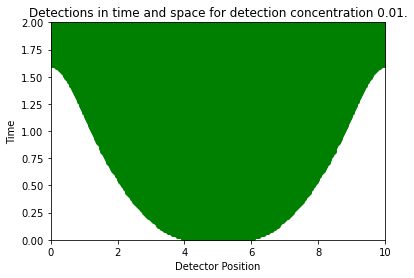

In [148]:
#plot of positions and times where detector can detect 1/100 concentration
detection_threshold=(1/100)*initial_concentration
detection_points_plot_single(detection_points(detection_threshold),'g')

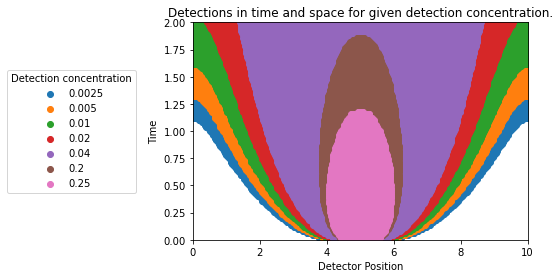

In [149]:
# loop over multiple detection thresholds
for detection_concentration in sorted([1/400,1/200,1/100,1/50,1/25,1/5,1/4],reverse=False):
    detection_threshold=detection_concentration*initial_concentration
    points_of_detection=detection_points(detection_threshold)
    plt.scatter(*zip(*points_of_detection),label=detection_concentration)
#plot
plt.axis([0, L, 0, T])
plt.legend(title='Detection concentration',loc="center right", bbox_to_anchor=(-.17, 0.5), borderaxespad=0)
plt.ylabel('Time')
plt.xlabel('Detector Position')
plt.title(f'Detections in time and space for given detection concentration.')
plt.show()

nb: Level curves, maybe elliptic? kinda egg shaped

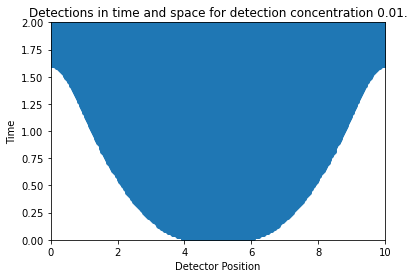

In [157]:
#test for later
detection_concentration=1/100
detection_threshold=detection_concentration*initial_concentration
points_of_detection=detection_points(detection_threshold)
detection_points_plot_single(points_of_detection)

In [158]:
def get_detection_boundary(points_of_detection=points_of_detection):
    '''get boundary of a **CONNECTED*** region of detection points'''
    detectction_boundary=[]
    position_gap=(L/Nx_spaces)
    time_gap=(T/Nt_gaps)
    for idx, [position, time] in enumerate(points_of_detection):
        #if not([position-position_gap,time] in points_of_detection) or not([position+position_gap,time] in points_of_detection):
        #if not(points_of_detection[idx-1][0]<=position+position_gap) or not(points_of_detection[idx+1][0]>=position-position_gap):
         if points_of_detection[idx-1][1]!=time or points_of_detection[(idx+1)%len(points_of_detection)][1]!=time:
            '''ONLY WORKS FOR CONNECTED REGIONS, probably use one of the above if not connected'''
            #print(idx,position,position-position_gap,points_of_detection[idx-1][0])
            detectction_boundary.append([position,time])
    return detectction_boundary
detectction_boundary=get_detection_boundary()

28987 202


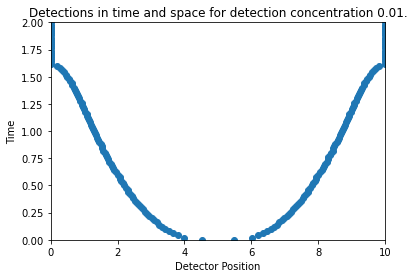

In [159]:
#boundary test
print(len(points_of_detection),len(detectction_boundary))

detection_points_plot_single(detectction_boundary)

The ellipse is given by $-0.0416x^2 +-0.000977y^2+0.417x+0.542y = 1$
Mean Error 0.0011129023618376545
202


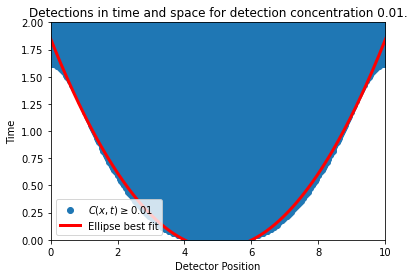

array([-0.04163012, -0.00097719,  0.41669723,  0.54242563])

In [160]:
#maybe its egg shaped instead: https://www.mathematische-basteleien.de/eggcurves.htm

def ellipse_fit(detectction_boundary):
    ''' fit an upright ellipse, ripped from so
    https://stackoverflow.com/questions/47873759/how-to-fit-a-2d-ellipse-to-given-points'''

    X = np.array(detectction_boundary)[:,0:1]
    Y = np.array(detectction_boundary)[:,1:]

    # Formulate and solve the least squares problem ||Ax - b ||^2
    A = np.hstack([X**2, Y**2, X, Y])
    b = np.ones_like(X)
    x = np.linalg.lstsq(A, b,rcond=None)[0].squeeze()

    # Print the equation of the ellipse in standard form
    print('The ellipse is given by ${0:.3}x^2 +{1:.3}y^2+{2:.3}x+{3:.3}y = 1$'.format(x[0], x[1],x[2],x[3]))

    # Plot the noisy data
    #plt.scatter(X, Y, label=f'$C(x,t)={detection_threshold}$')

    # Plot the least squares ellipse
    
    #x_coord = np.linspace(0,L,300)
    #y_coord = np.linspace(0,T,300)
    #X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
    #Z_coord = x[0] * X_coord ** 2 + x[1] * Y_coord**2 + x[2] * X_coord + x[3] * Y_coord
    #plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)
    #X_coord=[X_coord[i,j] for i in range(np.shape(Z_coord)[0]) for j in range(np.shape(Z_coord)[1]) if Z_coord[i,j]==1]
    #Y_coord=[Y_coord[i,j] for i in  range(np.shape(Z_coord)[0]) for j in range(np.shape(Z_coord)[1]) if Z_coord[i,j]==1]
    
    # Attempt #2
    
    X_coord=np.arange(min(X)-1,max(X)+1,(max(X)-min(X))/2000)
    Y_coord=(-x[3]+np.sqrt(x[3]**2-4*x[1]*(x[0]*X_coord**2+x[2]*X_coord-1)))/(2*x[1])
    Y_coord=[*Y_coord,*(-x[3]-np.sqrt(x[3]**2-4*x[1]*(x[0]*X_coord**2+x[2]*X_coord-1)))/(2*x[1])]
    X_coord=[*X_coord,*X_coord]
    plt.plot(X_coord,Y_coord,color='r',linewidth=3,label='Ellipse best fit')   
    #error
    MSE = np.mean(np.square(x[0] * X ** 2 + x[1] * Y**2 + x[2] * X + x[3] * Y-1))
    print('Mean Error',MSE)
    print(len(Y))

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis([0, L, 0, T])
    plt.ylabel('Time')
    plt.xlabel('Detector Position')
    plt.legend()
    plt.title(f'Detections in time and space for detection concentration {detection_threshold}.')
    plt.show()
    plt.show()
    return x

plt.scatter(*zip(*points_of_detection),label=f'$C(x,t)\geq{detection_threshold}$')
ellipse_fit(detectction_boundary)

C:\Users\trist\AppData\Local\Temp\ipykernel_5172\2784902486.py:10: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-(np.log(detection_concentration)+np.log(4*np.pi*D*Y_coord)/2)*4*D*Y_coord)
C:\Users\trist\AppData\Local\Temp\ipykernel_5172\2784902486.py:10: RuntimeWarning: invalid value encountered in multiply
  return np.sqrt(-(np.log(detection_concentration)+np.log(4*np.pi*D*Y_coord)/2)*4*D*Y_coord)


Mean Error 22.720601617585285


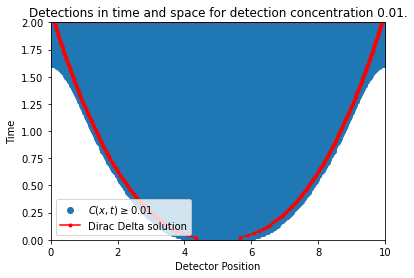

In [161]:
#plt.scatter(*zip(*detectction_boundary),label=f'$C(x,t)={detection_threshold}$')
plt.scatter(*zip(*points_of_detection),label=f'$C(x,t)\geq{detection_threshold}$')

#print(len(points_of_detection))

D=1

def exp_soln_invert(Y_coord):
    #analytic solution to level curve for dirac delta
    return np.sqrt(-(np.log(detection_concentration)+np.log(4*np.pi*D*Y_coord)/2)*4*D*Y_coord)

Y_coord=t[1:]
X_coord=exp_soln_invert(Y_coord)

plt.plot(np.concatenate((X_coord+L/2,np.flip(-X_coord+L/2))),np.concatenate((Y_coord,np.flip(Y_coord))),'r.-',label='Dirac Delta solution')

MSE = np.nanmean(np.square(exp_soln_invert(np.array(detectction_boundary)[:,0:])-np.array(detectction_boundary)[:,1:]))
print('Mean Error',MSE)

plt.axis([0, L, 0, T])
plt.ylabel('Time')
plt.xlabel('Detector Position')
plt.legend()
plt.title(f'Detections in time and space for detection concentration {detection_threshold}.')
plt.show()

In [208]:
#optimal sensor position
print(list(np.array(detectction_boundary)[:,1]).index(0.74))
print(detectction_boundary[74])
print(5-1.72-0.5)


print((L/2-exp_soln_invert(0.75)))

74
[1.725, 0.74]
2.7800000000000002
1.7672771080421992
